<a href="https://colab.research.google.com/github/alexlimatds/fact_extraction/blob/main/AILA2020/FACTS_AILA_SBERT_all_MiniLM_L6_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Facts extraction with AILA data and SBERT (all-MiniLM-L6-v2)

- for training: the train dataset from AILA 2020. This can be obtained at https://github.com/Law-AI/semantic-segmentation;
- for test: additional train documents from AILA 2021;

There are two forms of evaluation: 5-fold cross-validation and with the test set. The data split of the cross-validation approach is done in terms of documents instead sentences.


###Installing dependencies

In [1]:
# SBERT
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.9 MB/s 
     |████████████████████████████████| 4.0 MB 30.1 MB/s 
     |████████████████████████████████| 1.2 MB 54.1 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 6.6 MB 46.7 MB/s 
     |████████████████████████████████| 895 kB 56.9 MB/s 
     |████████████████████████████████| 596 kB 61.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=9877a84485bdaa57467f169f946c3a0701b2be73d2d0f3e024342b5304735b21
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


###Loading dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
g_drive_dir = "/content/gdrive/MyDrive/"

Mounted at /content/gdrive


In [3]:
!rm -r data
!mkdir data
!mkdir data/train
!tar -xf {g_drive_dir}fact_extraction_AILA/train.tar.xz -C data/train
!mkdir data/test
!tar -xf {g_drive_dir}fact_extraction_AILA/test.tar.xz -C data/test

train_dir = 'data/train/'
test_dir = 'data/test/'

rm: cannot remove 'data': No such file or directory


In [4]:
import pandas as pd
from os import listdir

def read_docs(dir_name):
  """
  Read the docs in a directory.
  Params:
    dir_name : the directory that contains the documents.
  Returns:
    A dictionary whose keys are the names of the read files and the values are 
    pandas dataframes. Each dataframe has sentence and label columns.
  """
  docs = {} # key: file name, value: dataframe with sentences and labels
  for f in listdir(dir_name):
    df = pd.read_csv(
        dir_name + f, 
        sep='\t', 
        names=['sentence', 'label'])
    docs[f] = df
  return docs

docs_train = read_docs(train_dir)
docs_test = read_docs(test_dir)

print(f'TRAIN: {len(docs_train)} documents read.')
print(f'TEST: {len(docs_test)} documents read.')

TRAIN: 50 documents read.
TEST: 10 documents read.


###Features

In [5]:
from sentence_transformers import SentenceTransformer

sent_encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [6]:
import numpy as np

# Train features
train_features = None
train_targets = []
docs_train_features = {} # key: file id, value: numpy matrix of features
for doc_id, df in docs_train.items():
  features = sent_encoder.encode(df['sentence'].to_list())
  docs_train_features[doc_id] = features
  if train_features is None:
    train_features = features
  else:
    train_features = np.vstack((train_features, features))
  train_targets.extend(df['label'].tolist())

print(f'{train_features.shape[0]} sentences.')

9380 sentences.


In [7]:
# Test features
test_features = None
test_targets = []
for df in docs_test.values():
  if test_features is None:
    test_features = sent_encoder.encode(df['sentence'].to_list())
  else:
    test_features = np.vstack((test_features, sent_encoder.encode(df['sentence'].to_list())))
  test_targets.extend(df['label'].tolist())

test_features.shape

(1673, 384)

### Evaluation functions

In [8]:
# Reading the file containing the sets of trains documents and test documents by fold
train_files_by_fold = {}  # Key: fold ID, value: file names (list of string)
test_files_by_fold = {}   # Key: fold ID, value: file names (list of string)

df_folds = pd.read_csv(
  g_drive_dir + 'fact_extraction_AILA/train_docs_by_fold.csv', 
  sep=';', 
  names=['fold id', 'train', 'test'], 
  header=0)

for _, row in df_folds.iterrows():
  train_files_by_fold[row['fold id']] = row['train'].split(',')
  test_files_by_fold[row['fold id']] = row['test'].split(',')

for fold_id in train_files_by_fold.keys():
  print(f'Fold {fold_id}: \n\tTrain files: {train_files_by_fold[fold_id]} \n\tTest files: {test_files_by_fold[fold_id]}')


Fold 0: 
	Train files: ['d_44.txt', 'd_39.txt', 'd_12.txt', 'd_2.txt', 'd_7.txt', 'd_33.txt', 'd_16.txt', 'd_8.txt', 'd_42.txt', 'd_34.txt', 'd_40.txt', 'd_24.txt', 'd_36.txt', 'd_11.txt', 'd_13.txt', 'd_19.txt', 'd_18.txt', 'd_4.txt', 'd_1.txt', 'd_21.txt', 'd_15.txt', 'd_23.txt', 'd_32.txt', 'd_9.txt', 'd_5.txt', 'd_3.txt', 'd_26.txt', 'd_20.txt', 'd_30.txt', 'd_41.txt', 'd_46.txt', 'd_43.txt', 'd_50.txt', 'd_27.txt', 'd_25.txt', 'd_35.txt', 'd_45.txt', 'd_17.txt', 'd_48.txt', 'd_6.txt'] 
	Test files: ['d_22.txt', 'd_31.txt', 'd_49.txt', 'd_14.txt', 'd_29.txt', 'd_47.txt', 'd_10.txt', 'd_38.txt', 'd_28.txt', 'd_37.txt']
Fold 1: 
	Train files: ['d_22.txt', 'd_31.txt', 'd_49.txt', 'd_14.txt', 'd_29.txt', 'd_47.txt', 'd_10.txt', 'd_38.txt', 'd_28.txt', 'd_37.txt', 'd_40.txt', 'd_24.txt', 'd_36.txt', 'd_11.txt', 'd_13.txt', 'd_19.txt', 'd_18.txt', 'd_4.txt', 'd_1.txt', 'd_21.txt', 'd_15.txt', 'd_23.txt', 'd_32.txt', 'd_9.txt', 'd_5.txt', 'd_3.txt', 'd_26.txt', 'd_20.txt', 'd_30.txt', 'd_

In [9]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support

def cross_validation(trainer):
  print('### Evaluation with cross-validation ###')
  train_metrics_cross = []
  test_metrics_cross = []
  for fold_id in train_files_by_fold.keys():
    print(f'Starting fold {fold_id}')
    # train features of the current fold
    train_features_fold = None
    train_targets_fold = []
    for doc_id in train_files_by_fold[fold_id]:
      if train_features_fold is None:
        train_features_fold = docs_train_features[doc_id]
      else:
        train_features_fold = np.vstack((train_features_fold, docs_train_features[doc_id]))
      train_targets_fold.extend(docs_train[doc_id]['label'].tolist())
    #training model
    model = trainer(train_features_fold, train_targets_fold)
    # test features of the current fold
    test_features_fold = None
    test_targets_fold = []
    for doc_id in test_files_by_fold[fold_id]:
      if test_features_fold is None:
        test_features_fold = docs_train_features[doc_id]
      else:
        test_features_fold = np.vstack((test_features_fold, docs_train_features[doc_id]))
      test_targets_fold.extend(docs_train[doc_id]['label'].tolist())
    # test metrics
    predictions = model.predict(test_features_fold)
    p_test, r_test, f1_test, _ = precision_recall_fscore_support(
        test_targets_fold, 
        predictions, 
        average='binary', 
        pos_label='Facts', 
        zero_division=0)
    test_metrics_cross.append([p_test, r_test, f1_test])
    # train metrics
    predictions = model.predict(train_features_fold)
    p_train, r_train, f1_train, _ = precision_recall_fscore_support(
        train_targets_fold, 
        predictions, 
        average='binary', 
        pos_label='Facts', 
        zero_division=0)
    train_metrics_cross.append([p_train, r_train, f1_train])
  
  test_metrics_cross = np.array(test_metrics_cross)
  test_mean = np.mean(test_metrics_cross, axis=0)
  test_std = np.std(test_metrics_cross, axis=0)
  train_metrics_cross = np.array(train_metrics_cross)
  train_mean = np.mean(train_metrics_cross, axis=0)
  train_std = np.std(train_metrics_cross, axis=0)
  
  print(f'Mean precision - std deviation => train: {train_mean[0]:.4f} {train_std[0]:.4f} \t test: {test_mean[0]:.4f} {test_std[0]:.4f}')
  print(f'Mean recall - std deviation    => train: {train_mean[1]:.4f} {train_std[1]:.4f} \t test: {test_mean[1]:.4f} {test_std[1]:.4f}')
  print(f'Mean f1 - std deviation        => train: {train_mean[2]:.4f} {train_std[2]:.4f} \t test: {test_mean[2]:.4f} {test_std[2]:.4f}')


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_metrics = {}

def evaluate_with_test_set(trainer):
  print('### Evaluation with the test set ###')
  # evaluation
  model = trainer(train_features, train_targets)
  predictions = model.predict(test_features)
  # Precision, Recall, F1
  t_metrics = precision_recall_fscore_support(
    test_targets, 
    predictions, 
    average='binary', 
    pos_label='Facts', 
    zero_division=0)
  test_metrics[model.__class__.__name__] = t_metrics
  print(f'Precision: {t_metrics[0]:.4f}')
  print(f'Recall:    {t_metrics[1]:.4f}')
  print(f'F-score:   {t_metrics[2]:.4f}')
  # Confusion matrix
  cm = confusion_matrix(
    test_targets, 
    predictions)
  ConfusionMatrixDisplay(cm, display_labels=['Other', 'Facts']).plot()

###Models

#### Default MLP from scikit-learn

In [11]:
from sklearn.neural_network import MLPClassifier

def default_mlp_trainer(X, y):
  mlp = MLPClassifier(early_stopping=True, random_state=1)
  return mlp.fit(X, y)

In [12]:
%%time
cross_validation(default_mlp_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.7880 0.0377 	 test: 0.5496 0.0890
Mean recall - std deviation    => train: 0.5942 0.1139 	 test: 0.3940 0.0742
Mean f1 - std deviation        => train: 0.6737 0.0901 	 test: 0.4478 0.0317
CPU times: user 17.1 s, sys: 9.3 s, total: 26.4 s
Wall time: 13.7 s


### Evaluation with the test set ###
Precision: 0.6314
Recall:    0.5515
F-score:   0.5887
CPU times: user 8.7 s, sys: 4.74 s, total: 13.4 s
Wall time: 6.91 s


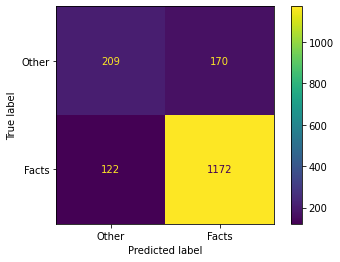

In [13]:
%%time
evaluate_with_test_set(default_mlp_trainer)

#### Linear SVM

In [14]:
from sklearn.svm import LinearSVC

def svm_trainer(X, y):
  svm = LinearSVC(random_state=1)
  return svm.fit(X, y)

In [15]:
%%time
cross_validation(svm_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.7219 0.0084 	 test: 0.5415 0.0754
Mean recall - std deviation    => train: 0.4894 0.0258 	 test: 0.3693 0.0701
Mean f1 - std deviation        => train: 0.5830 0.0187 	 test: 0.4310 0.0449
CPU times: user 2.7 s, sys: 544 ms, total: 3.24 s
Wall time: 2.69 s


### Evaluation with the test set ###
Precision: 0.6724
Recall:    0.5198
F-score:   0.5863
CPU times: user 661 ms, sys: 107 ms, total: 768 ms
Wall time: 655 ms


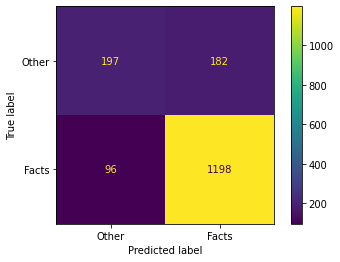

In [16]:
%%time
evaluate_with_test_set(svm_trainer)

#### RBF SVM

In [17]:
from sklearn.svm import SVC

def rbfsvm_trainer(X, y):
  rbfsvm = SVC(kernel='rbf', random_state=1)
  return rbfsvm.fit(X, y)

In [18]:
%%time

cross_validation(rbfsvm_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.9394 0.0081 	 test: 0.6272 0.0986
Mean recall - std deviation    => train: 0.6942 0.0250 	 test: 0.3333 0.0804
Mean f1 - std deviation        => train: 0.7980 0.0140 	 test: 0.4230 0.0592
CPU times: user 1min 17s, sys: 200 ms, total: 1min 17s
Wall time: 1min 18s


### Evaluation with the test set ###
Precision: 0.7935
Recall:    0.5172
F-score:   0.6262
CPU times: user 11.8 s, sys: 56.4 ms, total: 11.8 s
Wall time: 11.8 s


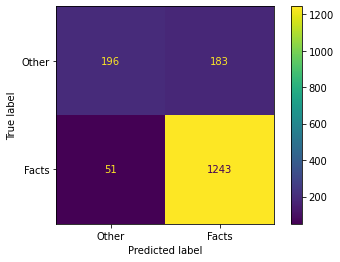

In [19]:
%%time

evaluate_with_test_set(rbfsvm_trainer)

#### Logistic regression

In [20]:
from sklearn.linear_model import LogisticRegression

def lr_trainer(X, y):
  logreg = LogisticRegression(solver='sag', max_iter=200, random_state=1)
  return logreg.fit(X, y)

In [21]:
%%time

cross_validation(lr_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.7265 0.0126 	 test: 0.5985 0.0849
Mean recall - std deviation    => train: 0.4215 0.0271 	 test: 0.3345 0.0782
Mean f1 - std deviation        => train: 0.5330 0.0228 	 test: 0.4193 0.0564
CPU times: user 5.01 s, sys: 499 ms, total: 5.51 s
Wall time: 4.94 s


### Evaluation with the test set ###
Precision: 0.7436
Recall:    0.4591
F-score:   0.5677
CPU times: user 1.19 s, sys: 98 ms, total: 1.29 s
Wall time: 1.17 s


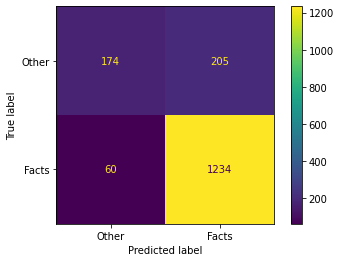

In [22]:
%%time

evaluate_with_test_set(lr_trainer)

#### KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier

def knn_trainer(X, y):
  knn = KNeighborsClassifier(5)
  return knn.fit(X, y)

In [24]:
%%time

cross_validation(knn_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.8261 0.0053 	 test: 0.4813 0.1042
Mean recall - std deviation    => train: 0.6434 0.0181 	 test: 0.3038 0.0660
Mean f1 - std deviation        => train: 0.7232 0.0122 	 test: 0.3607 0.0431
CPU times: user 18.2 s, sys: 3.15 s, total: 21.3 s
Wall time: 13.3 s


### Evaluation with the test set ###
Precision: 0.6029
Recall:    0.4406
F-score:   0.5091
CPU times: user 1.09 s, sys: 214 ms, total: 1.31 s
Wall time: 775 ms


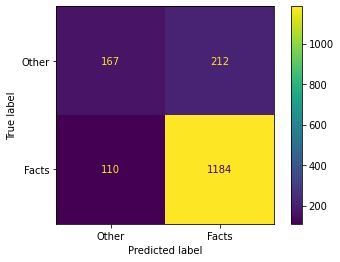

In [25]:
%%time

evaluate_with_test_set(knn_trainer)

#### Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree_trainer(X, y):
  dtree = DecisionTreeClassifier(random_state=1)
  return dtree.fit(X, y)

In [27]:
%%time

cross_validation(decision_tree_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.9982 0.0007 	 test: 0.3400 0.0892
Mean recall - std deviation    => train: 0.9955 0.0014 	 test: 0.3519 0.0309
Mean f1 - std deviation        => train: 0.9968 0.0007 	 test: 0.3392 0.0462
CPU times: user 34.7 s, sys: 36.1 ms, total: 34.7 s
Wall time: 34.6 s


### Evaluation with the test set ###
Precision: 0.3887
Recall:    0.3826
F-score:   0.3856


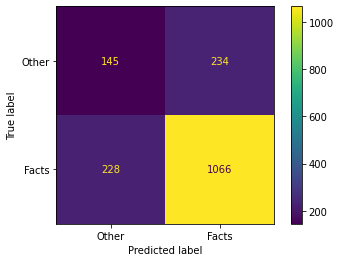

In [28]:
evaluate_with_test_set(decision_tree_trainer)

#### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_trainer(X, y):
  rforest = RandomForestClassifier(random_state=1)
  return rforest.fit(X, y)

In [30]:
cross_validation(random_forest_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.9997 0.0003 	 test: 0.7061 0.0821
Mean recall - std deviation    => train: 0.9931 0.0014 	 test: 0.0561 0.0282
Mean f1 - std deviation        => train: 0.9964 0.0008 	 test: 0.1015 0.0476


### Evaluation with the test set ###
Precision: 0.8800
Recall:    0.1161
F-score:   0.2051


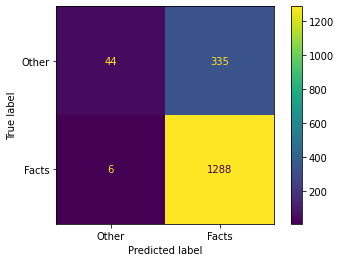

In [31]:
evaluate_with_test_set(random_forest_trainer)

#### AdaBoost

In [32]:
from sklearn.ensemble import AdaBoostClassifier

def adaboost_trainer(X, y):
  adab = AdaBoostClassifier(random_state=1)
  return adab.fit(X, y)

In [33]:
cross_validation(adaboost_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.6368 0.0143 	 test: 0.4857 0.0834
Mean recall - std deviation    => train: 0.4279 0.0259 	 test: 0.3119 0.0770
Mean f1 - std deviation        => train: 0.5115 0.0211 	 test: 0.3698 0.0474


### Evaluation with the test set ###
Precision: 0.6497
Recall:    0.3377
F-score:   0.4444


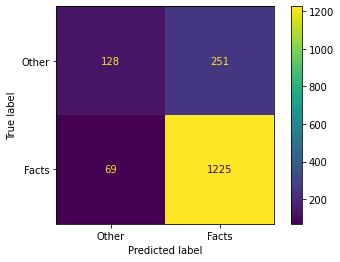

In [34]:
evaluate_with_test_set(adaboost_trainer)

#### Naive Bayes

In [35]:
from sklearn.naive_bayes import GaussianNB

def naive_bayes_trainer(X, y):
  nb = GaussianNB()
  return nb.fit(X, y)


In [36]:
cross_validation(naive_bayes_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.4542 0.0178 	 test: 0.4179 0.0827
Mean recall - std deviation    => train: 0.6916 0.0131 	 test: 0.6410 0.0795
Mean f1 - std deviation        => train: 0.5479 0.0110 	 test: 0.4988 0.0581


### Evaluation with the test set ###
Precision: 0.5881
Recall:    0.7309
F-score:   0.6518


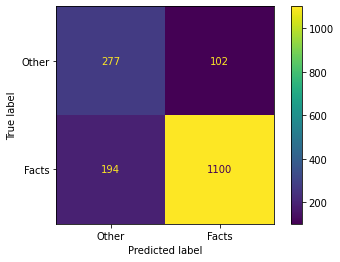

In [37]:
evaluate_with_test_set(naive_bayes_trainer)

#### XGBoost

In [38]:
from xgboost.sklearn import XGBClassifier
import torch

def xgboost_trainer(X, y):
  if torch.cuda.is_available():
    xgboost = XGBClassifier(objective="binary:logistic", tree_method='gpu_hist', gpu_id=0)
  else:
    xgboost = XGBClassifier(objective="binary:logistic", tree_method='hist')
  return xgboost.fit(X, y)


In [39]:
cross_validation(xgboost_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.8958 0.0158 	 test: 0.6401 0.1240
Mean recall - std deviation    => train: 0.4784 0.0280 	 test: 0.2357 0.0683
Mean f1 - std deviation        => train: 0.6230 0.0224 	 test: 0.3324 0.0557


### Evaluation with the test set ###
Precision: 0.7639
Recall:    0.2902
F-score:   0.4207


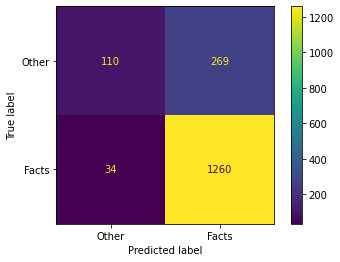

In [40]:
evaluate_with_test_set(xgboost_trainer)

### Results

In [41]:
from IPython.display import display, update_display

metrics_df = pd.DataFrame(columns=['Precision', 'Recall', 'F1'])
for model_name, metrics in test_metrics.items():
  metrics_df.loc[model_name] = [f'{metrics[0]:.4f}', f'{metrics[1]:.4f}', f'{metrics[2]:.4f}']
metrics_display = display(metrics_df, display_id='metrics_table')

,Precision,Recall,F1
MLPClassifier,0.6314,0.5515,0.5887
LinearSVC,0.6724,0.5198,0.5863
SVC,0.7935,0.5172,0.6262
LogisticRegression,0.7436,0.4591,0.5677
KNeighborsClassifier,0.6029,0.4406,0.5091
DecisionTreeClassifier,0.3887,0.3826,0.3856
RandomForestClassifier,0.8800,0.1161,0.2051
AdaBoostClassifier,0.6497,0.3377,0.4444
GaussianNB,0.5881,0.7309,0.6518
XGBClassifier,0.7639,0.2902,0.4207


### Reference paper:

> Paheli Bhattacharya, Shounak Paul, Kripabandhu Ghosh, Saptarshi Ghosh, and Adam Wyner. 2019. **Identification of Rhetorical Roles of Sentences in Indian Legal Judgments**. In Proc. International Conference on Legal Knowledge and Information Systems (JURIX).

